In [1]:
#Import the right libraries 
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from distutils.dir_util import copy_tree
import os
import random
import shutil
import array as arr
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import tensorflow as tf


In [2]:
    ##Getting images just for train for now. Will get the other in later. But use the train first to test some type of model to see baseline errors 
    BATCH_SIZE =16
    IMG_HEIGHT = 320
    IMG_WIDTH = 320

    sets_dir = '~/test_instance/Sets'

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
           # transforms.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
            transforms.ToTensor()
        ]),
        'val': transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
            #transforms.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
            transforms.ToTensor()
        ]),
        'test': transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
           #transforms.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
            transforms.ToTensor()
        ])
    }
    directories = {'train':'Training', 'val':'Dev', 'test': 'Test'}
    image_datasets = {x: datasets.ImageFolder(os.path.join(sets_dir, directories[x]),
                                              data_transforms[x])
                      for x in ['train', 'val', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'val', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
    class_names = image_datasets['train'].class_to_idx
    size = len(image_datasets['val'])
    print(size)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Class Names: " + str(class_names))

130
Class Names: {'COVID': 0, 'Non-COVID': 1}


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
CKPT_PATH = 'model.pth.tar'
N_CLASSES = 14
import time
import copy

def main():

    cudnn.benchmark = True

    # initialize and load the model
    modelmy = DenseNet121(N_CLASSES).cuda()

    #Below we need to get rid of the fact that the model was trained on multiple GPUs. Remove all instances of module.
    #and then reformat the remaining state dictionary to replace incompatible keys 
    if os.path.isfile(CKPT_PATH):
        print("===> loading checkpoint")
        
        import re
        # Code modified from torchvision densenet source for loading from pre .4 densenet weights.
        checkpoint = torch.load('./model.pth.tar')
        print(checkpoint.keys())
        state_dict = checkpoint['state_dict']
        
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove module.
            new_state_dict[name] = v
        
        state_dict = new_state_dict
        remove_data_parallel = False # Change if you don't want to use nn.DataParallel(model)
        
        print("===> Recompiling Data")
        pattern = re.compile(r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        for key in list(state_dict.keys()):
            match = pattern.match(key)
            new_key = match.group(1) + match.group(2) if match else key
            new_key = new_key[7:] if remove_data_parallel else new_key
            state_dict[new_key] = state_dict[key]
            # Delete old key only if modified.
            if match or remove_data_parallel: 
                del state_dict[key]

        print("===> Loading State Dictionary")
        modelmy.load_state_dict(state_dict)
        
        print("===> Removing the Classifier Layer")
        modelmy.densenet121.classifier = nn.Sequential(*list(modelmy.densenet121.classifier.children())[:-2])
        
        
        print('===> Freezing all other parameters')
        c = 0
        for param in modelmy.densenet121.parameters():
            c += 1
            if c>340:
                param.requires_grad = True
            else:
                param.requires_grad = False
            
        
        #Relink the last classifier layer as a 2 output sigmoid 
        print('===> Rewiring the classifier layer')
        
        modelmy.densenet121.classifier = nn.Sequential(nn.Linear(1024,1)).cuda()
        #nn.Sigmoid()
        print(modelmy)
      
        print("===> Importing new model to optimizer")
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([0.1633]).cuda())
        optimizer_dn121 = optim.Adam(modelmy.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_dn121, step_size=7, gamma=0.1)
        #opt = checkpoint['optimizer']

        model_dn121 = train_model(modelmy, criterion, optimizer_dn121, exp_lr_scheduler,num_epochs=25).cuda()
        return model_dn121 # Added this line
        
        
        print("===> loaded checkpoint")
    else:
        print("===> no checkpoint found")
        
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            true_positives = 0
            false_positives = 0
            true_negatives = 0
            false_negatives = 0
            c = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #c += 1
                #print(c)
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print(torch.max(inputs).cuda())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = (outputs>0.5) * 1
                    preds = preds.view(-1).cuda()
                    labels = labels.type(torch.FloatTensor).cuda()
                    outputs = outputs.view(-1).cuda()
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                true_positives_n, false_positives_n, true_negatives_n, false_negatives_n = confusion(preds,labels)
                true_positives += true_positives_n
                false_positives += false_positives_n
                true_negatives += true_negatives_n
                false_negatives += false_negatives_n
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            model.zero_grad()

            print('{} Loss: {:.4f} Acc: {:.4f} TP: {:.4f} FP: {:.4f} TN: {:.4f} FN: {:.4f}'.format(
                phase, epoch_loss, epoch_acc,true_positives, false_positives, true_negatives, false_negatives))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 14),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.densenet121(x)
        return x

In [4]:
model_dn121 = main()

===> loading checkpoint
dict_keys(['optimizer', 'epoch', 'arch', 'state_dict'])
===> Recompiling Data
===> Loading State Dictionary
===> Removing the Classifier Layer
===> Freezing all other parameters
===> Rewiring the classifier layer
DenseNet121(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

Epoch 0/24
----------
train Loss: 0.1594 Acc: 0.4947 TP: 356.0000 FP: 11.0000 TN: 159.0000 FN: 515.0000
val Loss: 0.2338 Acc: 0.7769 TP: 43.0000 FP: 7.0000 TN: 58.0000 FN: 22.0000

Epoch 1/24
----------
train Loss: 0.1197 Acc: 0.7368 TP: 614.0000 FP: 17.0000 TN: 153.0000 FN: 257.0000
val Loss: 0.2594 Acc: 0.7923 TP: 47.0000 FP: 9.0000 TN: 56.0000 FN: 18.0000

Epoch 2/24
----------
train Loss: 0.1171 Acc: 0.6657 TP: 533.0000 FP: 10.0000 TN: 160.0000 FN: 338.0000
val Loss: 0.2808 Acc: 0.8385 TP: 54.0000 FP: 10.0000 TN: 55.0000 FN: 11.0000

Epoch 3/24
----------
train Loss: 0.0922 Acc: 0.8319 TP: 710.0000 FP: 14.0000 TN: 156.0000 FN: 161.0000
val Loss: 0.1710 Acc: 0.8077 TP: 44.0000 FP: 4.0000 TN: 61.0000 FN: 21.0000

Epoch 4/24
----------
train Loss: 0.0708 Acc: 0.8540 TP: 726.0000 FP: 7.0000 TN: 163.0000 FN: 145.0000
val Loss: 0.2022 Acc: 0.8538 TP: 53.0000 FP: 7.0000 TN: 58.0000 FN: 12.0000

Epoch 5/24
----------
train Loss: 0.0639 Acc: 0.8905 TP: 759.0000 FP: 2.0000 TN: 168.0000 FN: 1

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
#inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])

In [176]:
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = labels.to(device)

img_choice = random.randrange(0, inputs.shape[0], 1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
_DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.

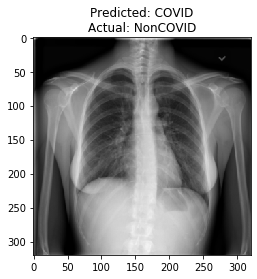

In [236]:
data = inputs[img_choice] # Choose a random image to examine
data_to_plot = data.cpu() # Storing data for plotting later
data.unsqueeze_(0) # Processing to pull out activations

visualisation = {}

def hook_fn(m, i, o):
    visualisation[m] = o
    
def get_all_layers_dn(net): #densenet specific hooks
    for item in net.densenet121._modules['features']:
        item.register_forward_hook(hook_fn)

def get_all_layers(net):
    if isinstance(net.densenet121._modules['features'], nn.Sequential): #if model is densenet, uses dn function to get to layers
        get_all_layers_dn(net)
    else:
        for name, layer in net._modules.items(): #otherwise iterates over modules.items()
    #If it is a sequential, don't register a hook on it
    # but recursively register hook on all it's module children
            if isinstance(layer, nn.Sequential):
                get_all_layers(layer)
            else:
      # it's a non sequential. Register a hook
                layer.register_forward_hook(hook_fn)


get_all_layers(model_dn121)
out = model_dn121(data)

_, preds = torch.max(out, 1)

if preds.cpu().numpy()[0] == class_names['COVID']:
    title1 = 'Predicted: COVID'
else:
    title1 = 'Predicted: NonCOVID'
if labels.cpu()[img_choice].numpy() == class_names['COVID']:
    title2 = 'Actual: COVID'
else:
    title2 = 'Actual: NonCOVID'

imshow(data_to_plot, title = title1 + '\n' + title2)

In [237]:
print(class_names)
print(preds.cpu().numpy()[0])
print(labels.cpu()[img_choice].numpy())

{'COVID': 0, 'Non-COVID': 1}
0
1


In [231]:
def display_activations(visualisation, filters_to_plot = 16, nrows = 4):
    ncols = filters_to_plot//nrows
    counter = 0
    for key in visualisation.keys():
        counter+=1
        act = visualisation[key].cpu()
        img_data = act.data.numpy()
        if img_data.ndim == 4 and img_data.shape[-1] == img_data.shape[-2]:# and img_data.shape[-1] >= IMG_HEIGHT/4: # only plotting activations when not too discretized
            fig1, f1_axes = plt.subplots(ncols, nrows, constrained_layout=True, figsize=(10,10))
            fig1.suptitle(str(key)[:50]) #Only plotting first 50 characters, some titles get too long
            for i in range(filters_to_plot): #
                f1_axes[i//(ncols), i%(ncols)].imshow(img_data[0,i,:]) #currently just plotting first n filters instead of random

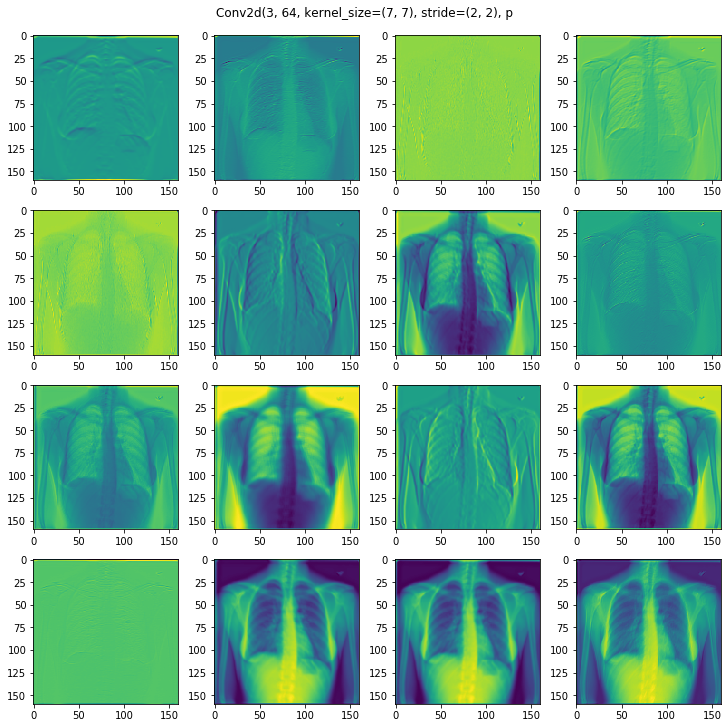

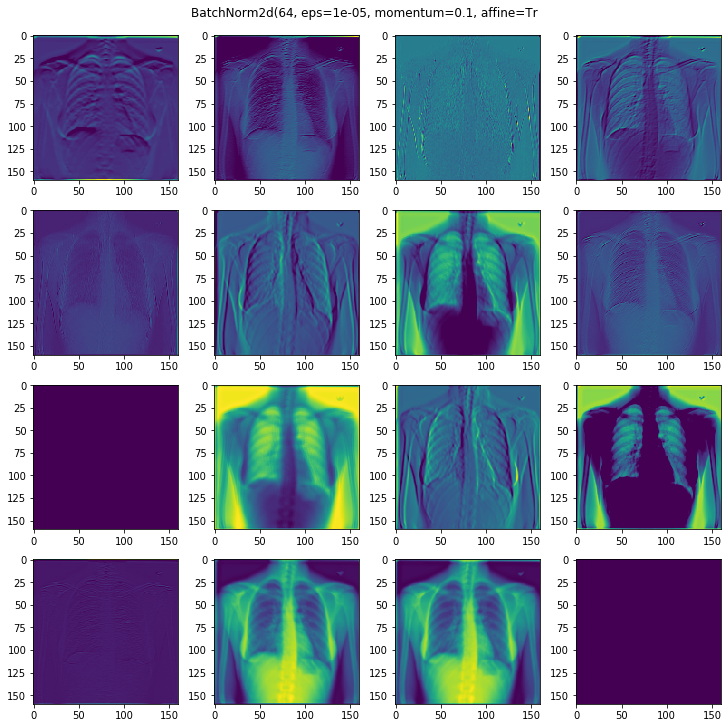

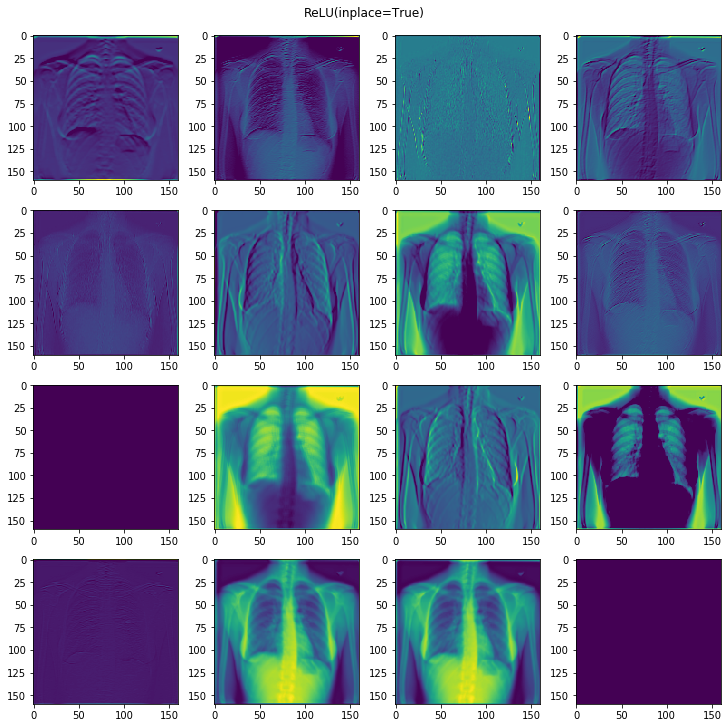

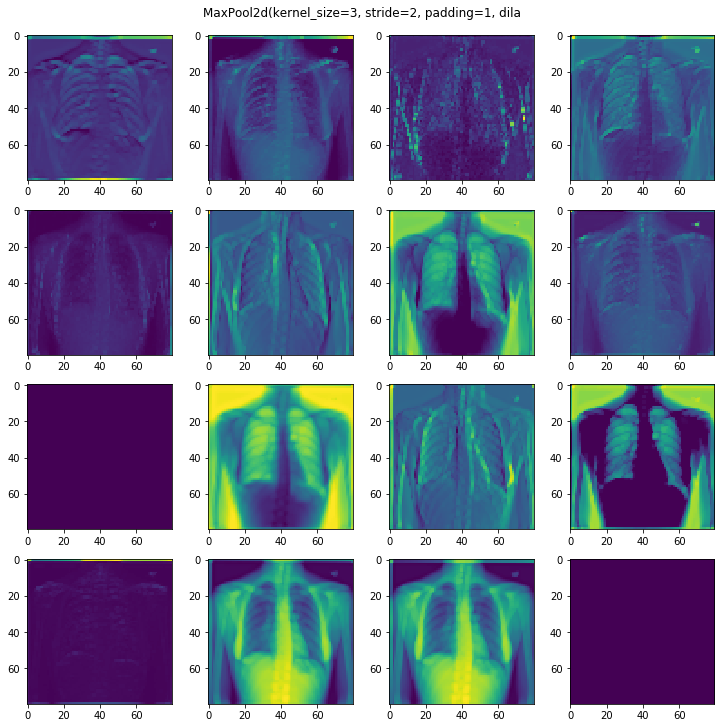

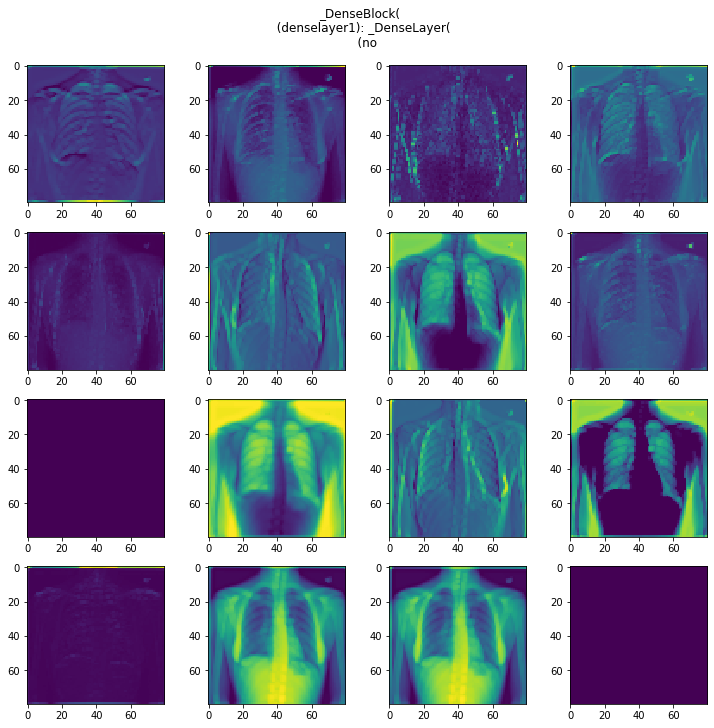

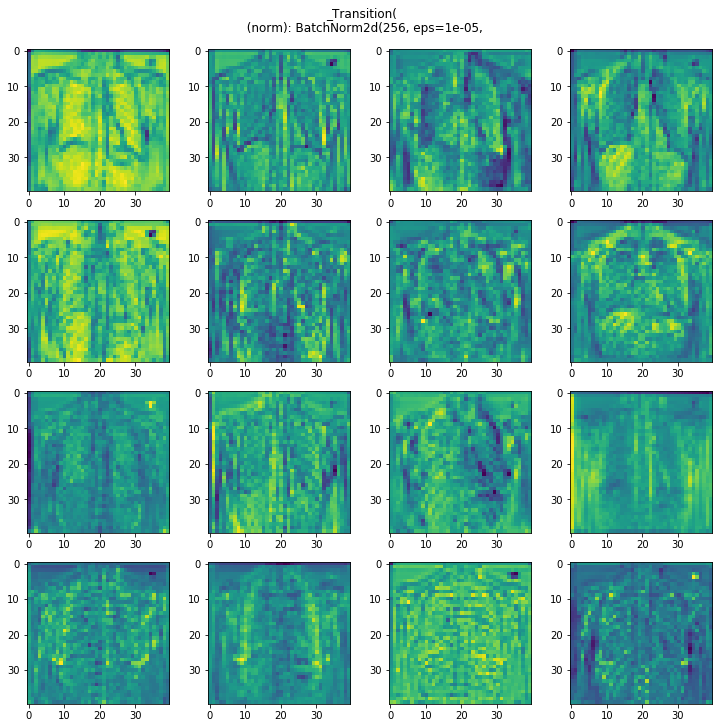

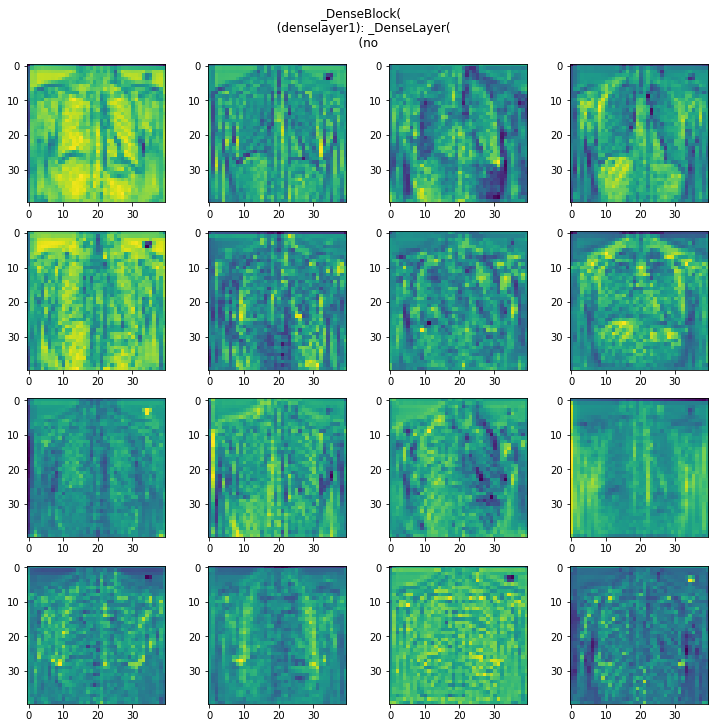

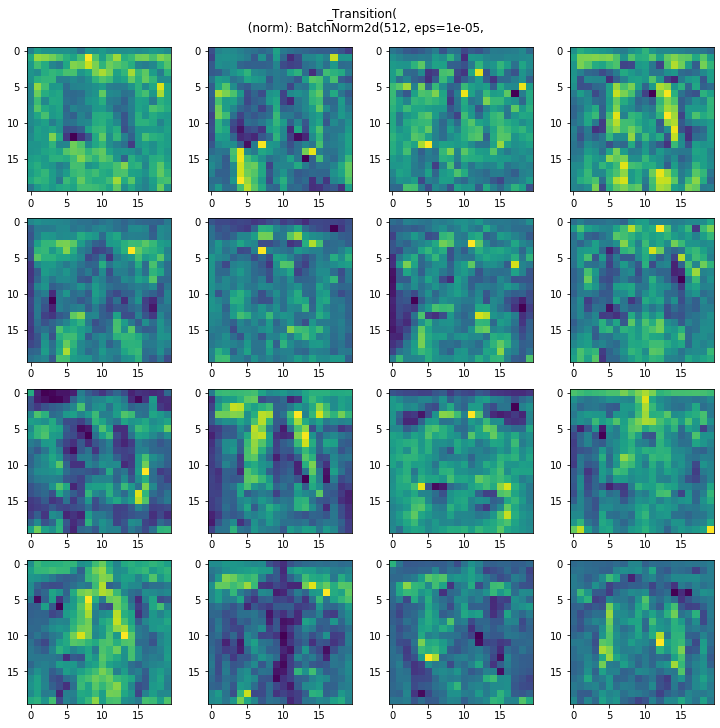

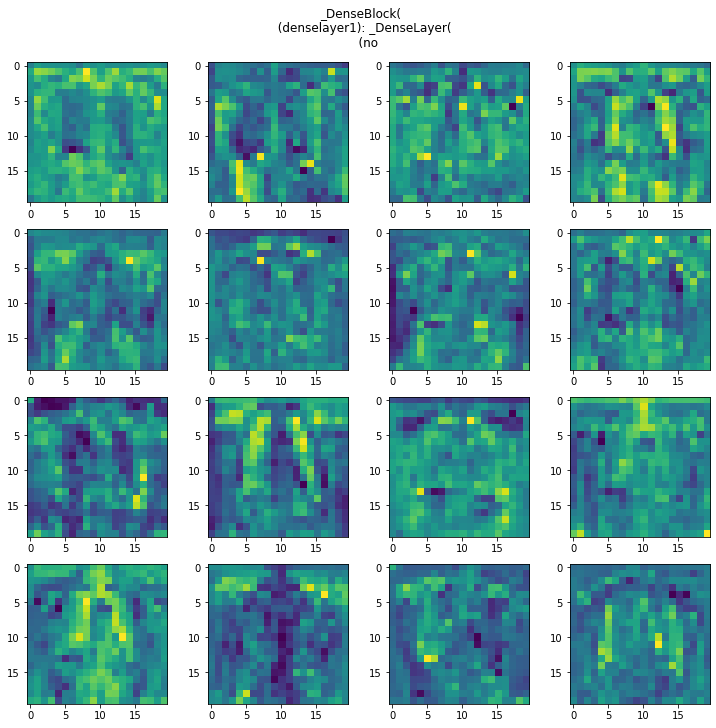

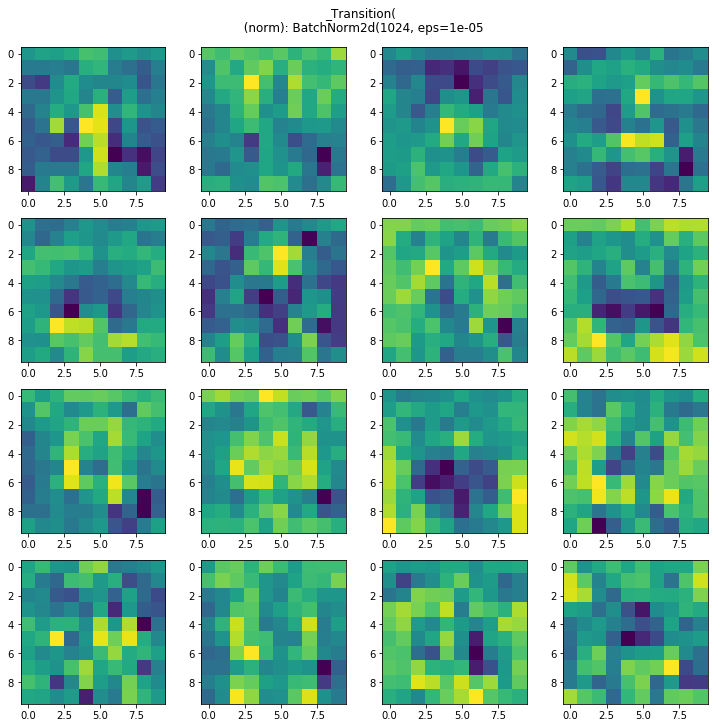

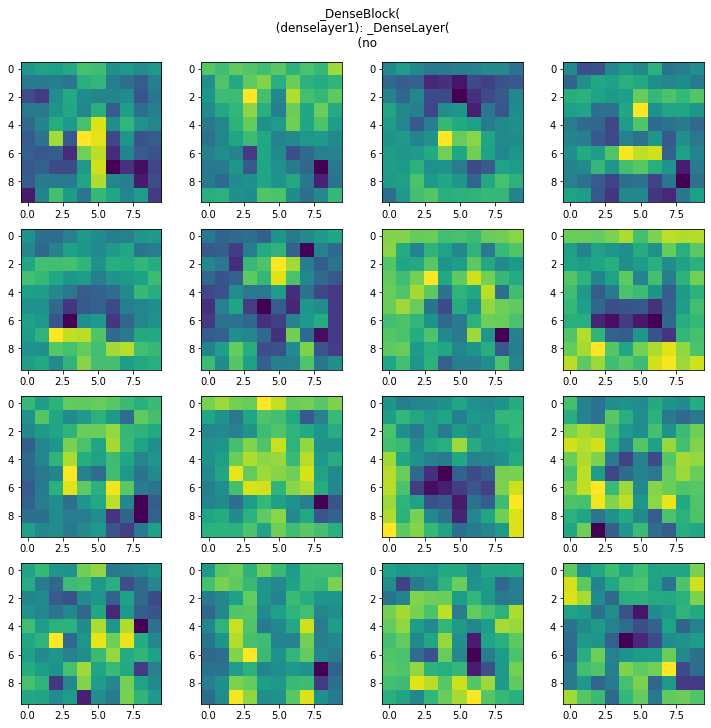

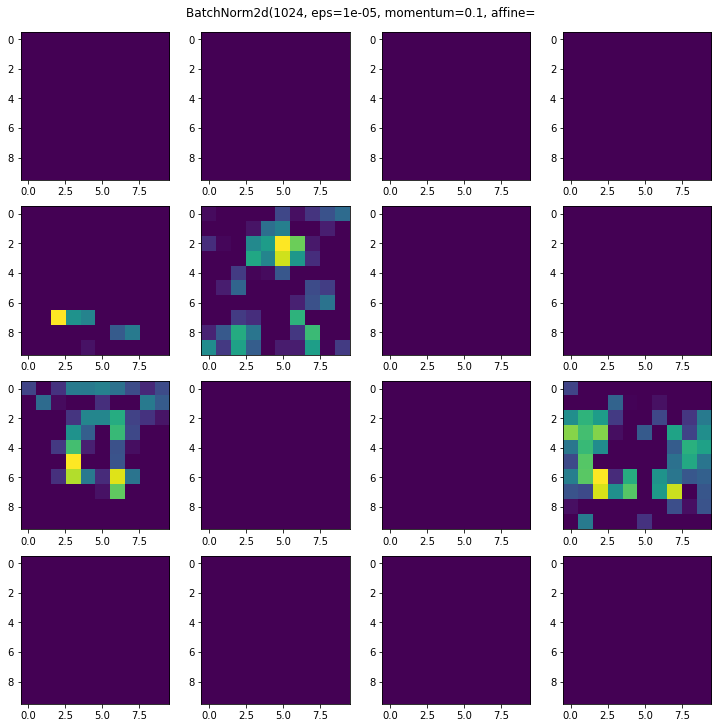

In [238]:
filters_to_plot = 16
nrows = 4
display_activations(visualisation, filters_to_plot, nrows)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
_DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.

{Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): tensor([[[[-5.7005e+00, -6.5900e+00, -4.6320e+00,  ..., -4.9554e+00,
           -5.3660e+00, -3.9507e+00],
          [ 1.3459e+00,  3.0906e+00,  4.4287e+00,  ...,  7.0296e+00,
            6.9737e+00,  5.0878e+00],
          [ 3.1632e+00,  4.4491e+00,  4.0686e+00,  ...,  6.1207e+00,
            6.5197e+00,  4.8595e+00],
          ...,
          [ 6.4270e-02,  1.4070e-01,  9.8062e-02,  ...,  2.9146e-01,
            3.9824e-01,  1.3102e-01],
          [-1.4328e-02,  2.3948e-02, -1.1370e-01,  ...,  3.0892e-01,
            1.1279e-01,  6.0666e-02],
          [ 1.9139e+00,  2.3318e+00,  1.9896e+00,  ...,  2.9338e+00,
            2.4694e+00,  1.8505e+00]],

         [[-9.8794e-01, -3.6158e-01,  6.4369e-01,  ..., -3.0942e-01,
           -2.6898e-01,  3.7611e-01],
          [ 7.0045e-02,  9.9130e-01,  1.1657e+00,  ...,  1.3893e+00,
            1.3191e+00,  1.1852e+00],
          [ 2.5553e-01,  4.1942e-01,  2.7214e-01

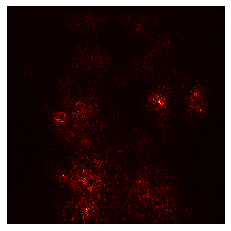

In [239]:
# From : https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4
# preprocess the image
X = data

# we would run the model in evaluation mode
model_dn121.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model_dn121(X)

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot)
plt.axis('off')
plt.show()

In [194]:
def imshow_heatmap(inp, heatmap, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    fig = plt.figure(frameon=False)
    if title is not None:
        plt.title(title)
    im1 = plt.imshow(inp)
    im2 =  plt.imshow(heatmap, cmap = plt.cm.hot, alpha = 0.5)
    plt.show()
    plt.pause(0.001)

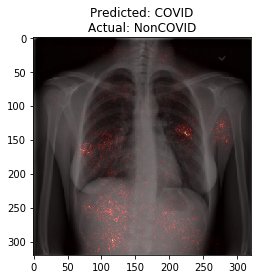

In [240]:
imshow_heatmap(data_to_plot, saliency[0].cpu(), title = title1 + '\n' + title2)

In [ ]:
# Useful for visualization, but not critical for running this model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]) + '\n actual: {}'.format(class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)